In [95]:
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import torchvision
from torchvision import transforms,datasets
from shutil import copy, rmtree
import json

In [96]:
def mk_file(file_path: str):
    if os.path.exists(file_path):
        rmtree(file_path)
    os.makedirs(file_path)
def split_data():
    split_rate = 0.25
    data_root = 'F:/postgraduate-study/deep Learning-wan/data/third_data'
    origin_car_path = os.path.join(data_root, "traffic_data")
    assert os.path.exists(origin_car_path), "path '{}' does not exist.".format(origin_car_path)
    car_class = [cla for cla in os.listdir(origin_car_path) if os.path.isdir(os.path.join(origin_car_path, cla))]

  # 建立保存训练集的文件夹
    train_root = os.path.join(data_root, "train")
    mk_file(train_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(train_root, cla))

  # 建立保存验证集的文件夹
    test_root = os.path.join(data_root, "test")
    mk_file(test_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(test_root, cla))
    for cla in car_class:
        print(cla)
        cla_path = os.path.join(origin_car_path, cla)
        images = os.listdir(cla_path)
        num = len(images)
    # 随机采样验证集的索引
        eval_index = random.sample(images, k=int(num*split_rate))
        for index, image in enumerate(images):
            if image in eval_index:
      # 将分配至验证集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(test_root, cla)
                copy(image_path, new_path)
            else:
      # 将分配至训练集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(train_root, cla)
                copy(image_path, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
    print("processing done!")
split_data()

bus
[bus] processing [219/219]car
[car] processing [779/779]truck
[truck] processing [360/360]processing done!


In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {"train": transforms.Compose([transforms.Resize((64,64)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),
(0.5,0.5,0.5))]),"test": transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])}


image_path = 'F:/postgraduate-study/deep Learning-wan/data/third_data'
print(image_path)
train_dataset = datasets.ImageFolder(root=os.path.join(image_path,"train"),transform = data_transform["train"])
train_num = len(train_dataset)
print(train_num)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)

test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),transform = data_transform["test"])

test_num = len(test_dataset)
print(test_num)#val_num = 364
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,num_workers = 0)
print("using {} images for training, {} images for validation .".format(train_num,test_num))

using cuda:0 device.
F:/postgraduate-study/deep Learning-wan/data/third_data
1019
338
using 1019 images for training, 338 images for validation .


In [98]:
class ConvModule(nn.Module):  
    def __init__(self):
        super(ConvModule,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(
        #第一层  
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
        # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
        #第二层  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,58)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out  


In [99]:
lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

In [100]:
## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)  
    time_list.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.664785,test_loss 0.669801,train_acc 0.754661,test_acc 0.727811,Time used 3.176058s
epoch 2, train_loss 0.509464,test_loss 0.528981,train_acc 0.819431,test_acc 0.807692,Time used 3.002324s
epoch 3, train_loss 0.500253,test_loss 0.464964,train_acc 0.818449,test_acc 0.825444,Time used 2.999419s
epoch 4, train_loss 0.466626,test_loss 0.412236,train_acc 0.839058,test_acc 0.860947,Time used 3.062111s
epoch 5, train_loss 0.423921,test_loss 0.405590,train_acc 0.851816,test_acc 0.857988,Time used 3.050326s
epoch 6, train_loss 0.427070,test_loss 0.568936,train_acc 0.841021,test_acc 0.739645,Time used 2.994270s
epoch 7, train_loss 0.368474,test_loss 0.368204,train_acc 0.869480,test_acc 0.875740,Time used 2.990482s
epoch 8, train_loss 0.363368,test_loss 0.668833,train_acc 0.866536,test_acc 0.701183,Time used 2.993047s
epoch 9, train_loss 0.395668,test_loss 0.475656,train_acc 0.856722,test_acc 0.846154,Time used 3.030613s
epoch 10, train_loss 0.358810,test_loss 0.334445

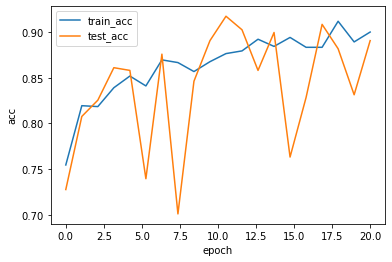

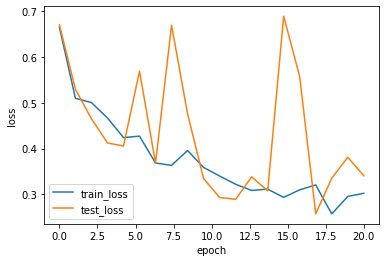

In [101]:
def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
    for i in args:
        x = np.linspace(0,len(i[0]),len(i[0]))
        plt.plot(x,i[0],label=i[1],linewidth=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
Draw_Curve([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])


In [102]:
class ConvModule_layer2(nn.Module):  
    def __init__(self):
        super(ConvModule_layer2,self).__init__()  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(64,3)  
    def forward(self,x):  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,60)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule_layer2().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

In [103]:
## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_layer2 = []
train_acc_list_layer2 = []
test_loss_list_layer2 = []
test_acc_list_layer2 = []
time_list_layer2 = []
timestart_layer2 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_layer2.append(train_loss)  
    train_acc_list_layer2.append(train_acc )  
    test_loss_list_layer2.append(test_loss)  
    test_acc_list_layer2.append(test_acc)  
    time_list_layer2.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_layer2)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.799683,test_loss 0.775361,train_acc 0.698724,test_acc 0.689349,Time used 1.965549s
epoch 2, train_loss 0.672012,test_loss 0.647839,train_acc 0.770363,test_acc 0.766272,Time used 1.688136s
epoch 3, train_loss 0.641486,test_loss 0.616687,train_acc 0.779195,test_acc 0.807692,Time used 1.685277s
epoch 4, train_loss 0.602412,test_loss 0.601989,train_acc 0.801766,test_acc 0.819527,Time used 1.717256s
epoch 5, train_loss 0.580498,test_loss 0.552745,train_acc 0.817468,test_acc 0.828402,Time used 1.723305s
epoch 6, train_loss 0.545969,test_loss 0.535623,train_acc 0.827282,test_acc 0.834320,Time used 1.696222s
epoch 7, train_loss 0.523933,test_loss 0.572351,train_acc 0.828263,test_acc 0.772189,Time used 1.732051s
epoch 8, train_loss 0.529679,test_loss 0.488995,train_acc 0.818449,test_acc 0.834320,Time used 1.694036s
epoch 9, train_loss 0.500222,test_loss 0.458361,train_acc 0.832188,test_acc 0.852071,Time used 1.697411s
epoch 10, train_loss 0.468936,test_loss 0.526737

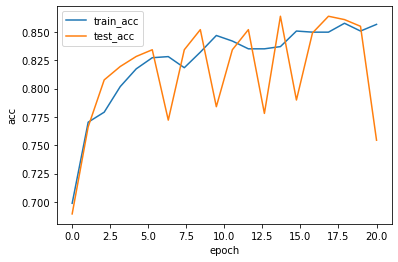

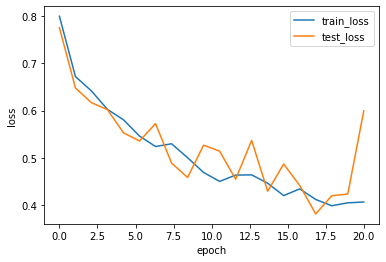

In [104]:
Draw_Curve([train_acc_list_layer2,"train_acc"],[test_acc_list_layer2,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_layer2,"train_loss"],[test_loss_list_layer2,"test_loss"])


In [105]:
class ConvModule_layer4(nn.Module):  
    def __init__(self):
        super(ConvModule_layer4,self).__init__()  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 64, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,56)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule_layer4().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_layer4 = []
train_acc_list_layer4 = []
test_loss_list_layer4 = []
test_acc_list_layer4 = []
time_list_layer4 = []
timestart_layer4 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_layer4.append(train_loss)  
    train_acc_list_layer4.append(train_acc )  
    test_loss_list_layer4.append(test_loss)  
    test_acc_list_layer4.append(test_acc)  
    time_list_layer4.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_layer4)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.612728,test_loss 0.683327,train_acc 0.786065,test_acc 0.680473,Time used 3.387184s
epoch 2, train_loss 0.478535,test_loss 0.626961,train_acc 0.822375,test_acc 0.778107,Time used 3.291857s
epoch 3, train_loss 0.449634,test_loss 0.510487,train_acc 0.836114,test_acc 0.828402,Time used 3.295522s
epoch 4, train_loss 0.396620,test_loss 0.888917,train_acc 0.850834,test_acc 0.763314,Time used 3.269544s
epoch 5, train_loss 0.372355,test_loss 0.442444,train_acc 0.852797,test_acc 0.863905,Time used 3.260606s
epoch 6, train_loss 0.348789,test_loss 1.175183,train_acc 0.871443,test_acc 0.674556,Time used 3.259317s
epoch 7, train_loss 0.371714,test_loss 0.412062,train_acc 0.859666,test_acc 0.849112,Time used 3.282197s
epoch 8, train_loss 0.323651,test_loss 0.385793,train_acc 0.880275,test_acc 0.893491,Time used 3.255541s
epoch 9, train_loss 0.299875,test_loss 0.541585,train_acc 0.892051,test_acc 0.778107,Time used 3.268326s
epoch 10, train_loss 0.297996,test_loss 0.286833

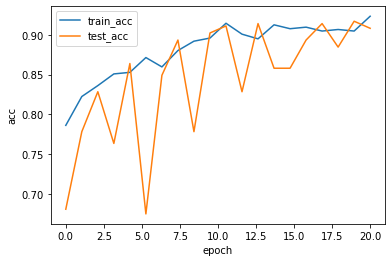

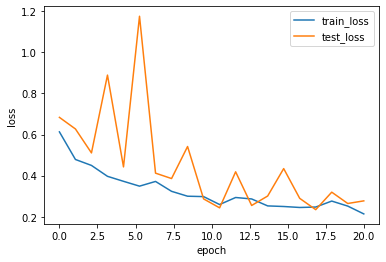

In [106]:
Draw_Curve([train_acc_list_layer4,"train_acc"],[test_acc_list_layer4,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_layer4,"train_loss"],[test_loss_list_layer4,"test_loss"])

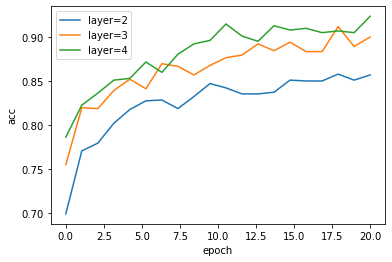

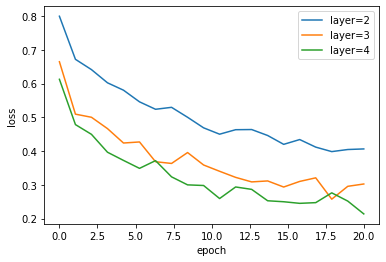

In [107]:
Draw_Curve([train_acc_list_layer2,"layer=2"],[train_acc_list,"layer=3"],[train_acc_list_layer4,"layer=4"],ylabel = "acc")
Draw_Curve([train_loss_list_layer2,"layer=2"],[train_loss_list,"layer=3"],[train_loss_list_layer4,"layer=4"])

In [108]:
class ConvModule_k4(nn.Module):  
    def __init__(self):
        super(ConvModule_k4,self).__init__()  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 4 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 4 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 4 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,55)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule_k4().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_k4 = []
train_acc_list_k4 = []
test_loss_list_k4 = []
test_acc_list_k4 = []
time_list_k4 = []
timestart_k4 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_k4.append(train_loss)  
    train_acc_list_k4.append(train_acc )  
    test_loss_list_k4.append(test_loss)  
    test_acc_list_k4.append(test_acc)  
    time_list_k4.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_k4)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.659942,test_loss 0.658858,train_acc 0.756624,test_acc 0.736686,Time used 3.414472s
epoch 2, train_loss 0.498692,test_loss 0.440394,train_acc 0.829244,test_acc 0.837278,Time used 3.338576s
epoch 3, train_loss 0.461095,test_loss 0.390161,train_acc 0.842002,test_acc 0.863905,Time used 3.313677s
epoch 4, train_loss 0.441891,test_loss 0.365751,train_acc 0.835132,test_acc 0.878698,Time used 3.368327s
epoch 5, train_loss 0.375709,test_loss 0.426137,train_acc 0.862610,test_acc 0.819527,Time used 3.362933s
epoch 6, train_loss 0.387732,test_loss 0.453596,train_acc 0.858685,test_acc 0.857988,Time used 3.329461s
epoch 7, train_loss 0.341457,test_loss 0.307515,train_acc 0.882237,test_acc 0.896450,Time used 3.334960s
epoch 8, train_loss 0.382015,test_loss 0.813105,train_acc 0.861629,test_acc 0.727811,Time used 3.337492s
epoch 9, train_loss 0.359084,test_loss 0.328935,train_acc 0.864573,test_acc 0.878698,Time used 3.322127s
epoch 10, train_loss 0.365929,test_loss 0.334706

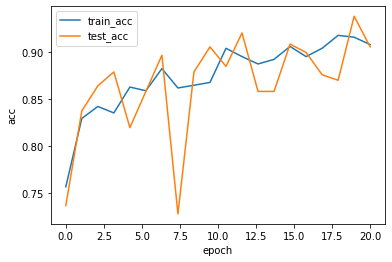

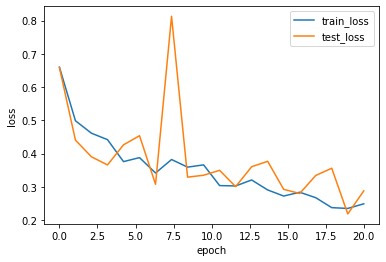

In [109]:
Draw_Curve([train_acc_list_k4,"train_acc"],[test_acc_list_k4,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_k4,"train_loss"],[test_loss_list_k4,"test_loss"])

In [110]:
class ConvModule_k5(nn.Module):  
    def __init__(self):
        super(ConvModule_k5,self).__init__()  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 5 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 5 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 5 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,52)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule_k5().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_k5 = []
train_acc_list_k5 = []
test_loss_list_k5 = []
test_acc_list_k5 = []
time_list_k5 = []
timestart_k5 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_k5.append(train_loss)  
    train_acc_list_k5.append(train_acc )  
    test_loss_list_k5.append(test_loss)  
    test_acc_list_k5.append(test_acc)  
    time_list_k5.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_k5)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.659968,test_loss 0.714130,train_acc 0.768400,test_acc 0.680473,Time used 2.895490s
epoch 2, train_loss 0.489596,test_loss 0.495957,train_acc 0.824338,test_acc 0.801775,Time used 2.775401s
epoch 3, train_loss 0.457628,test_loss 0.400295,train_acc 0.829244,test_acc 0.855030,Time used 2.783795s
epoch 4, train_loss 0.400484,test_loss 0.550485,train_acc 0.856722,test_acc 0.784024,Time used 2.762828s
epoch 5, train_loss 0.392042,test_loss 0.372423,train_acc 0.861629,test_acc 0.852071,Time used 2.739373s
epoch 6, train_loss 0.377455,test_loss 0.529031,train_acc 0.876349,test_acc 0.798817,Time used 2.722110s
epoch 7, train_loss 0.334835,test_loss 0.419131,train_acc 0.879293,test_acc 0.846154,Time used 2.741794s
epoch 8, train_loss 0.324485,test_loss 0.354130,train_acc 0.892051,test_acc 0.863905,Time used 2.726701s
epoch 9, train_loss 0.293273,test_loss 0.384738,train_acc 0.887144,test_acc 0.855030,Time used 2.734420s
epoch 10, train_loss 0.292436,test_loss 0.392782

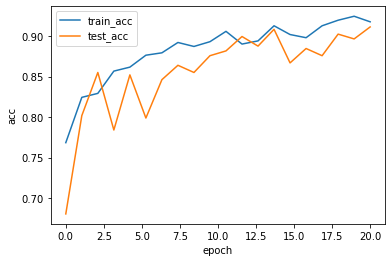

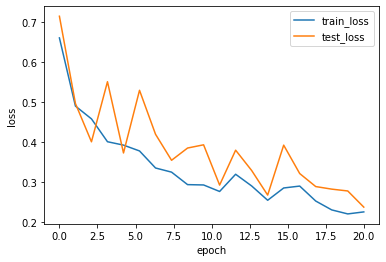

In [111]:
Draw_Curve([train_acc_list_k5,"train_acc"],[test_acc_list_k5,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_k5,"train_loss"],[test_loss_list_k5,"test_loss"])

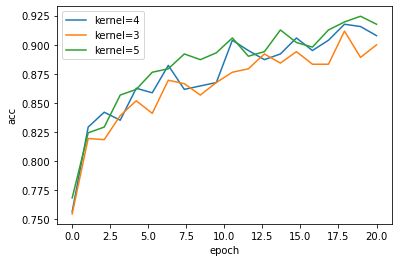

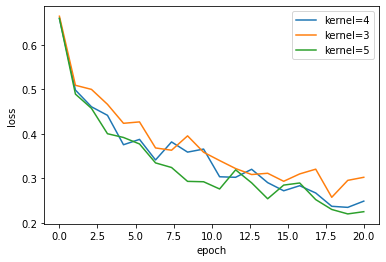

In [114]:
Draw_Curve([train_acc_list_k4,"kernel=4"],[train_acc_list,"kernel=3"],[train_acc_list_k5,"kernel=5"],ylabel = "acc")
Draw_Curve([train_loss_list_k4,"kernel=4"],[train_loss_list,"kernel=3"],[train_loss_list_k5,"kernel=5"])